In [1]:
import numpy as np
"""
Give, two x,y curves this gives intersection points,
autor: Sukhbinder
5 April 2017

Based on: http://uk.mathworks.com/matlabcentral/fileexchange/11837-fast-and-robust-curve-intersections

Lidong Guo copy this code from https://github.com/sukhbinder/intersection
"""

def _rect_inter_inner(x1, x2):
    n1 = x1.shape[0]-1
    n2 = x2.shape[0]-1
    X1 = np.c_[x1[:-1], x1[1:]]
    X2 = np.c_[x2[:-1], x2[1:]]
    S1 = np.tile(X1.min(axis=1), (n2, 1)).T
    S2 = np.tile(X2.max(axis=1), (n1, 1))
    S3 = np.tile(X1.max(axis=1), (n2, 1)).T
    S4 = np.tile(X2.min(axis=1), (n1, 1))
    return S1, S2, S3, S4


def _rectangle_intersection_(x1, y1, x2, y2):
    S1, S2, S3, S4 = _rect_inter_inner(x1, x2)
    S5, S6, S7, S8 = _rect_inter_inner(y1, y2)

    C1 = np.less_equal(S1, S2)
    C2 = np.greater_equal(S3, S4)
    C3 = np.less_equal(S5, S6)
    C4 = np.greater_equal(S7, S8)

    ii, jj = np.nonzero(C1 & C2 & C3 & C4)
    return ii, jj

def intersection(x1, y1, x2, y2):
    """
INTERSECTIONS Intersections of curves.
   Computes the (x,y) locations where two curves intersect.  The curves
   can be broken with NaNs or have vertical segments.

usage:
x,y=intersection(x1,y1,x2,y2)

    Example:
    a, b = 1, 2
    phi = np.linspace(3, 10, 100)
    x1 = a*phi - b*np.sin(phi)
    y1 = a - b*np.cos(phi)

    x2=phi
    y2=np.sin(phi)+2
    x,y=intersection(x1,y1,x2,y2)

    plt.plot(x1,y1,c='r')
    plt.plot(x2,y2,c='g')
    plt.plot(x,y,'*k')
    plt.show()

    """
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)

    ii, jj = _rectangle_intersection_(x1, y1, x2, y2)
    n = len(ii)

    dxy1 = np.diff(np.c_[x1, y1], axis=0)
    dxy2 = np.diff(np.c_[x2, y2], axis=0)

    T = np.zeros((4, n))
    AA = np.zeros((4, 4, n))
    AA[0:2, 2, :] = -1
    AA[2:4, 3, :] = -1
    AA[0::2, 0, :] = dxy1[ii, :].T
    AA[1::2, 1, :] = dxy2[jj, :].T

    BB = np.zeros((4, n))
    BB[0, :] = -x1[ii].ravel()
    BB[1, :] = -x2[jj].ravel()
    BB[2, :] = -y1[ii].ravel()
    BB[3, :] = -y2[jj].ravel()

    for i in range(n):
        try:
            T[:, i] = np.linalg.solve(AA[:, :, i], BB[:, i])
        except:
            T[:, i] = np.Inf

    in_range = (T[0, :] >= 0) & (T[1, :] >= 0) & (
        T[0, :] <= 1) & (T[1, :] <= 1)

    xy0 = T[2:, in_range]
    xy0 = xy0.T
    return xy0[:, 0], xy0[:, 1]

In [2]:
"""
Lidong Guo copy this code from https://blog.csdn.net/cunyizhang/article/details/112461070
"""
import math
def __line_magnitude(x1, y1, x2, y2):
    lineMagnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
    return lineMagnitude
 
def point_to_line_distance(point, A,B):
    px, py = point
    x1, y1, x2, y2 = A[0],A[1],B[0],B[1]
    line_magnitude = __line_magnitude(x1, y1, x2, y2)
    if line_magnitude < 0.00000001:
        return 9999
    else:
        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (line_magnitude * line_magnitude)
        if (u < 0.00001) or (u > 1):
            ix = __line_magnitude(px, py, x1, y1)
            iy = __line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance = iy
            else:
                distance = ix
        else:
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance = __line_magnitude(px, py, ix, iy)
        return distance
    

In [3]:
"""
Get anchors for pair-wise alignment.

Autor: Lidong Guo
Data: 13 Sep. 2022

Based on the scheme of https://doi.org/10.1038/s41593-017-0027-7, which origin from https://doi.org/10.1016/B978-0-12-372560-8.X5000-1
"""
import numpy as np
import pandas as pd
import math
from skimage.filters import threshold_otsu
from skimage import measure
from sklearn.decomposition import PCA


def GetAnchors(img_array, binsize =50, components=1, round=4):
    #############################
    # step 01, binary
    def binaryImage(img_array):
        #thresh = threshold_otsu(img_array)
        binary = img_array > 0#thresh
        return binary
    binary_img = binaryImage(img_array)
    
    #############################
    # step 02, downsample
    def downSample(inimage,binsize=50):
        H,W = inimage.shape
        new_H, new_W = H//binsize, W//binsize
        y, x = np.nonzero(inimage)
        new_y = y / binsize
        new_x = x / binsize
        new_image = np.zeros((new_H,new_W))
        new_image[new_y.astype(int),new_x.astype(int)] = 1
        return new_image
    small_binary_img = downSample(binary_img,binsize)

    #############################
    # step 03, get contour(s)
    def findContour(inimage, ncomponet=1 ):
        contours = measure.find_contours(inimage)
        idx = []
        clen = []
        for i,contour in enumerate(contours):
            n,_ = contour.shape
            idx.append(i)
            clen.append(n)
        tmp = pd.DataFrame()
        tmp['idx'] = idx
        tmp['clen'] = clen
        tmp = tmp.sort_values(by='clen',ascending=False)
        ret = []
        for i in range(ncomponet):
            biggest = tmp.iloc[i]['idx']
            ctmp = pd.DataFrame()
            ctmp['x'] = contours[biggest][:, 1]
            ctmp['y'] = contours[biggest][:, 0]
            ret.append(ctmp)
        #ret = pd.concat(ret,ignore_index=True)
        return ret
    
    contour_0 = findContour(small_binary_img,components)
    contour = pd.concat(contour_0,ignore_index=True)
    ###############################################
    # get intersections between line and contours
    def intersection_contours(contours, line_x,line_y):
        ret_x , ret_y = [] , []
        for contour_tmp in contours:
            intersection_x , intersection_y = intersection(contour_tmp[:,0], contour_tmp[:,1],line_x,line_y)
            for i,x in enumerate(intersection_x):
                ret_x.append(x)
                ret_y.append(intersection_y[i])
        return ret_x, ret_y
    #############################
    # step 04, get anchor(s)
    def getAnchorsFromContour(contour_xy_0, round=4):
        contour_xy = pd.concat(contour_xy_0,ignore_index=True)
        pca = PCA(n_components=2)
        pca.fit(contour_xy[['x','y']].to_numpy())
        new_coord = pca.transform(contour_xy[['x','y']].to_numpy())
        new_coord_0 = []
        for contour_tmp in contour_xy_0:
            new_coord_0.append(pca.transform(contour_tmp[['x','y']].to_numpy()))
        left_right_x, _ = intersection_contours(new_coord_0,[-100,100],[0,0])
        right, left = [ np.max(left_right_x) , 0],  [np.min(left_right_x),0]
        _, updown_y = intersection_contours(new_coord_0,[0,0],[-100,100])
        up, down = [0,  np.max(updown_y)], [0,  np.min(updown_y)]
        anchors = np.array([up,right,down,left])
        if round <2:
            return np.dot(anchors,pca.components_)+pca.mean_

        def check_nearest(point,A,B,all_segments):
            dis_curr = point_to_line_distance(point, A,B)
            all_dis = []
            for seg in all_segments:
                all_dis.append(point_to_line_distance(point, seg[0],seg[1]))
            return dis_curr == min(all_dis)
        
        def midAnchor(now_contours, A, B, huge_dis=100,all_segments=[]):
            mid_in_line = np.mean(np.array([A,B]),axis=0)
            if A[0] == B[0]:
                checkline_x, checkline_y = [mid_in_line[0]-100, mid_in_line[0]+huge_dis], [mid_in_line[1],mid_in_line[1]]
            elif A[1] == B[1]:
                checkline_x, checkline_y = [mid_in_line[0], mid_in_line[0]], [mid_in_line[1]-huge_dis,mid_in_line[1]+huge_dis]
            else:
                slope = (B[1]-A[1]) / (B[0]-A[0])
                check_slope = -1/slope
                RP = mid_in_line + np.array([1,check_slope]) * huge_dis /  np.linalg.norm(np.array([1,check_slope]))
                LP = mid_in_line + np.array([1,check_slope]) * -huge_dis /  np.linalg.norm(np.array([1,check_slope]))
                checkline_x, checkline_y = [LP[0],RP[0]], [LP[1],RP[1]]
            intersect_x, intersect_y = intersection_contours(now_contours,checkline_x,checkline_y)
            if len(intersect_x)>1:
                flags = []
                for i in range(len(intersect_x)):
                    flags.append(check_nearest([intersect_x[i], intersect_y[i]],A,B,all_segments))
                flags = np.array(flags)
                if np.sum(flags)>0:
                    idx = np.nonzero(flags)
                    intersect_xx = np.array(intersect_x)[idx]
                    intersect_yy = np.array(intersect_y)[idx] 
                    intersect_x = intersect_xx
                    intersect_y = intersect_yy
            if len(intersect_x)>1:
                dist = huge_dis*100
                closest_idx = -1
                for i in range(len(intersect_x)):
                    curr_dis = math.dist([B[0],B[1]],[intersect_x[i], intersect_y[i]])
                    if curr_dis < dist:
                        dist = curr_dis
                        closest_idx = i 
                if closest_idx == -1:
                    raise Exception("Sorry, no closest!")
                return True , [intersect_x[closest_idx], intersect_y[closest_idx]]
            if len(intersect_x)<=0:
                return False , [0,0] #Exception("Sorry, no intersection!")
            return True,[intersect_x[0], intersect_y[0]]
        
        def all_segments(anchors):
            ret = []
            for m in range(anchors.shape[0]):
                if m != anchors.shape[0]-1:
                    ret.append([anchors[m],anchors[m+1]])
                else:
                    ret.append([anchors[m],anchors[0]])
            return ret
        
        for i in range(round-1):
            new_anchors = []
            for i in range(round-1):
                all_jumps =  all_segments(anchors)
                new_anchors = []
                for jump in all_jumps:
                    new_anchors.append(jump[0])
                    TF, mid = midAnchor(new_coord_0,jump[0],jump[1],all_segments=all_jumps)
                    if TF :
                        new_anchors.append(mid)
            new_anchors = np.array(new_anchors)
            anchors = new_anchors
        anchors_in_raw = np.dot(anchors, pca.components_)+pca.mean_
        return anchors_in_raw, new_coord_0, anchors, pca

    anchors, pca_contour, pca_anchors ,pca = getAnchorsFromContour(contour_0,round)
    raw_contour = [x*binsize for x in contour_0]
    raw_anchors = anchors*binsize
    return raw_contour, raw_anchors, pca_contour, pca_anchors, pca

In [4]:
""""
Lidong Guo copy from https://github.com/RuoyuChen10/Shape_Context_Matching
"""
def Shape_Context(points, angle=12, distance=[0,0.125,0.25,0.5,1.0,2.0]):
    """
    形状上下文直方图矩阵的构建
    points: 输入的采样点 shape[N,2]
    angle:  划分的角度区域个数
    distance: 划分的距离区域
    """
    # 计算欧式距离矩阵
    N = points.shape[0]
    dist = np.sqrt(np.sum(np.square(points.reshape((1,N,2)) - points.reshape((N,1,2))), axis=-1))
    
    # 距离均值
    mean_dist = np.sum(dist) / (N*N-N)
    # 除以均值，减少缩放敏感性
    dist = np.log(dist/mean_dist+0.000000000001) + np.eye(N, dtype=int) * 999
    # print(dist)

    # 角度计算
    theta = np.arctan((points[:,1].reshape(1,N)-points[:,1].reshape(N,1))/(points[:,0].reshape(1,N)-points[:,0].reshape(N,1)+0.000000000001))/math.pi + ((points[:,0].reshape(1,N)-points[:,0].reshape(N,1))<0).astype(int) + 0.5   # range(0, 2)

    histogram_feature = np.zeros((N, angle, len(distance)))

    for i in range(angle):
        # angle range
        angle_matrix = (theta > (2/angle * i)) * (theta <= (2/angle * (i+1)))
        for j in range(1,len(distance)):
            distance_matrix = (dist < distance[j]) * (dist > distance[j-1])

            histogram_feature[:,i,j-1] = np.sum(angle_matrix * distance_matrix, axis = 1)
    return histogram_feature

def Cost_function_Shape_Context(histogram1, histogram2):
    """
    代价矩阵
    histogram1: N1*A*D
    histogram2: N2*A*D
    """
    A = histogram1.shape[1]
    D = histogram1.shape[2]
    N1 = histogram1.shape[0]
    N2 = histogram2.shape[0]
    assert histogram1.shape[1] == histogram2.shape[1]
    assert histogram1.shape[2] == histogram2.shape[2]
    cost = 0.5 * np.sum(np.sum(
        np.square(
            histogram1.reshape((N1,1,A,D)) - histogram2.reshape((1,N2,A,D))) / (histogram1.reshape((N1,1,A,D)) + histogram2.reshape((1,N2,A,D))+0.000000001)
        ,axis=-1),axis=-1)
    return cost


In [5]:
import cv2
# Copyright 2018 Christoph Heindl.
#
# Licensed under MIT License
# ============================================================

import numpy as np

class TPS:       
    @staticmethod
    def fit(c, lambd=0., reduced=False):        
        n = c.shape[0]

        U = TPS.u(TPS.d(c, c))
        K = U + np.eye(n, dtype=np.float32)*lambd

        P = np.ones((n, 3), dtype=np.float32)
        P[:, 1:] = c[:, :2]

        v = np.zeros(n+3, dtype=np.float32)
        v[:n] = c[:, -1]

        A = np.zeros((n+3, n+3), dtype=np.float32)
        A[:n, :n] = K
        A[:n, -3:] = P
        A[-3:, :n] = P.T
        #try:
        theta = np.linalg.solve(A, v) # p has structure w,a
        #except:
        #    theta = np.linalg.lstsq(A, v)
        return theta[1:] if reduced else theta
        
    @staticmethod
    def d(a, b):
        return np.sqrt(np.square(a[:, None, :2] - b[None, :, :2]).sum(-1))

    @staticmethod
    def u(r):
        return r**2 * np.log(r + 1e-6)

    @staticmethod
    def z(x, c, theta):
        x = np.atleast_2d(x)
        U = TPS.u(TPS.d(x, c))
        w, a = theta[:-3], theta[-3:]
        reduced = theta.shape[0] == c.shape[0] + 2
        if reduced:
            w = np.concatenate((-np.sum(w, keepdims=True), w))
        b = np.dot(U, w)
        return a[0] + a[1]*x[:, 0] + a[2]*x[:, 1] + b

def uniform_grid(shape):
    '''Uniform grid coordinates.
    
    Params
    ------
    shape : tuple
        HxW defining the number of height and width dimension of the grid

    Returns
    -------
    points: HxWx2 tensor
        Grid coordinates over [0,1] normalized image range.
    '''

    H,W = shape[:2]    
    c = np.empty((H, W, 2))
    c[..., 0] = np.linspace(0, 1, W, dtype=np.float32)
    c[..., 1] = np.expand_dims(np.linspace(0, 1, H, dtype=np.float32), -1)

    return c
    
def tps_theta_from_points(c_src, c_dst, reduced=False):
    delta = c_src - c_dst
    
    cx = np.column_stack((c_dst, delta[:, 0]))
    cy = np.column_stack((c_dst, delta[:, 1]))
        
    theta_dx = TPS.fit(cx, reduced=reduced)
    theta_dy = TPS.fit(cy, reduced=reduced)

    return np.stack((theta_dx, theta_dy), -1)


def tps_grid(theta, c_dst, dshape):    
    ugrid = uniform_grid(dshape)

    #reduced = c_dst.shape[0] + 2 == theta.shape[0]

    dx = TPS.z(ugrid.reshape((-1, 2)), c_dst, theta[:, 0]).reshape(dshape[:2])
    dy = TPS.z(ugrid.reshape((-1, 2)), c_dst, theta[:, 1]).reshape(dshape[:2])
    dgrid = np.stack((dx, dy), -1)

    grid = dgrid + ugrid
    
    return grid # H'xW'x2 grid[i,j] in range [0..1]

def tps_grid_to_remap(grid, sshape):
    '''Convert a dense grid to OpenCV's remap compatible maps.

    Params
    ------
    grid : HxWx2 array
        Normalized flow field coordinates as computed by compute_densegrid.
    sshape : tuple
        Height and width of source image in pixels.

    Returns
    -------
    mapx : HxW array
    mapy : HxW array
    '''

    mx = (grid[:, :, 0] * sshape[1]).astype(np.float32)
    my = (grid[:, :, 1] * sshape[0]).astype(np.float32)

    return mx, my

def show_warped(img, warped,c_src,c_dst):
    fig, axs = plt.subplots()
    axs.imshow(img[...,::],cmap='binary' )
    axs.scatter(c_src[:, 0], c_src[:, 1] ,marker='+', color='black')
    plt.show()
    fig, axs = plt.subplots()
    axs.imshow(warped[...,::],cmap='binary')
    axs.scatter(c_dst[:, 0], c_dst[:, 1], marker='+', color='black')
    plt.show()

def warp_image_cv(img, c_src, c_dst, dshape=None):
    dshape = dshape or img.shape
    theta = tps_theta_from_points(c_src, c_dst, reduced=True)
    grid = tps_grid(theta, c_dst, dshape)
    mapx, mapy = tps_grid_to_remap(grid, img.shape)
    return cv2.remap(img, mapx, mapy, cv2.INTER_NEAREST	)

In [6]:
import matplotlib.pyplot as plt
import skimage.io as skio

def debugImage(img_filename,drawimg=True,n=4,binsize=50,show=True,components=1):
    img_array = skio.imread(img_filename)
    contour , anchors,  pca_contour, pca_anchors,pca  = GetAnchors(img_array,round=n,binsize = binsize,components=components)
    if show :
        fig, ax = plt.subplots()
        if drawimg:
            ax.imshow(img_array,cmap=plt.cm.gray)
        for contour_tmp in contour:
            ax.plot(contour_tmp['x'], contour_tmp['y'], linewidth=2,c='r')
        ax.scatter(anchors[:,0],anchors[:,1],c='g')
        ax.set_aspect('equal')
        plt.show()
        fig, ax = plt.subplots()
        for contour_tmp in pca_contour:
            ax.plot(contour_tmp[:,0], contour_tmp[:,1], linewidth=2,c='r')
        ax.scatter(pca_anchors[:,0],pca_anchors[:,1],c='g')
        ax.set_aspect('equal')
        plt.show()
    return img_array, contour , anchors,  pca_contour, pca_anchors,pca


In [7]:
from scipy.optimize import linear_sum_assignment
class Matching:
    def __init__(self,anchors_ref,anchors_reg,pca_ref,pca_reg,pca_anchors_ref,pca_anchors_reg,pca_contour_ref,pca_coutour_reg):
        self.pca_ref = pca_ref
        self.anchors_ref = anchors_ref
        self.pca_anchors_ref = pca_anchors_ref
        self.pca_reg= pca_reg
        self.anchors_reg = anchors_reg
        self.pca_anchors_reg = pca_anchors_reg
        self.pca_contour_ref = pca_contour_ref
        self.pca_coutour_reg = pca_coutour_reg
        self.manu_anchors_ref = []
        self.manu_anchors_reg = []
        self.manu_pca_anchors_ref = []
        self.manu_pca_anchors_reg = []
    
    def initAssignment(self):
        hist = Shape_Context(self.pca_anchors_ref)
        hist_reg = Shape_Context(self.pca_anchors_reg)
        cost_matrix = Cost_function_Shape_Context(hist,hist_reg)
        self.row_ind, self.col_ind = linear_sum_assignment(cost_matrix)
        self.curr_ref_idx = self.row_ind
        self.curr_reg_idx = self.col_ind
    
    def drawAssignment(self):
        plt.figure()
        plt.scatter(self.curr_ref_idx,self.curr_reg_idx)
        plt.show()
    
    def delAnchorPair(self, idx_in_ref):
        ref_idx = [] 
        reg_idx = []
        for i in range(len(self.curr_ref_idx)):
            if self.curr_ref_idx[i] == idx_in_ref:
                continue
            ref_idx.append(self.curr_ref_idx[i])
            reg_idx.append(self.curr_reg_idx[i])
        self.curr_ref_idx = ref_idx
        self.curr_reg_idx = reg_idx

    def drawMatchResult(self, shift=30):
        fig, axs = plt.subplots(figsize=(30,10))
        # draw ref anchor, contour and anchor id
        axs.scatter(self.pca_anchors_ref[:,0],self.pca_anchors_ref[:,1]*-1)
        for xx  in self.pca_contour_ref:
            axs.plot(xx[:,0],xx[:,1]*-1)
        for i in range(self.pca_anchors_ref.shape[0]):
            axs.text(self.pca_anchors_ref[i,0], -self.pca_anchors_ref[i,1],f'{i}',ha='center',va='center',fontsize=25,)
        # draw reg anchor, contour and anchor id
        axs.scatter(self.pca_anchors_reg[:,0]+shift,-1*(self.pca_anchors_reg[:,1]+shift))
        for xx  in self.pca_coutour_reg:
            axs.plot(xx[:,0]+shift,(xx[:,1]+shift)*-1)
        for i in range(self.pca_anchors_reg.shape[0]):
            axs.text(self.pca_anchors_reg[i,0]+shift, -1*(self.pca_anchors_reg[i,1]+shift),f'{i}',ha='center',va='center',fontsize=25,)
        # draw anchor correspondence
        for i in range(len(self.curr_ref_idx)):
            axs.plot([self.pca_anchors_ref[self.curr_ref_idx[i],0] , self.pca_anchors_reg[self.curr_reg_idx[i],0]+shift],
                     [self.pca_anchors_ref[self.curr_ref_idx[i],1]*-1 ,(self.pca_anchors_reg[self.curr_reg_idx[i],1]+shift)*-1])
            
        # draw manu anchor and Correspondence
        if len(self.manu_pca_anchors_ref)>0:
            for i in range(len(self.manu_pca_anchors_ref)):
                axs.plot( [self.manu_pca_anchors_ref[i,0], self.manu_pca_anchors_reg[i,0]+shift], 
                          [self.manu_pca_anchors_ref[i,1]*-1, (self.manu_pca_anchors_reg[i,1]+shift)*-1],c='r',linestyle = 'dashed')

        axs.set_aspect('equal')
        plt.show()
    
    def addAnchorPair(self,idx_ref,idx_reg):
        self.curr_ref_idx.append(idx_ref)
        self.curr_reg_idx.append(idx_reg)

    def addLanmarkPair(self,pos_ref, pos_reg,ref_binsize,reg_binsize):
        self.manu_anchors_ref.append(pos_ref)
        self.manu_anchors_reg.append(pos_reg)
        self.manu_pca_anchors_ref = self.pca_ref.transform(np.array(self.manu_anchors_ref)/ref_binsize)
        self.manu_pca_anchors_reg = self.pca_reg.transform(np.array(self.manu_anchors_reg)/reg_binsize)

    def GetAnchors(self):
        ref_anchors = []
        reg_anchors = []
        for i in range(len(self.curr_ref_idx)):
            ref_anchors.append(self.anchors_ref[self.curr_ref_idx[i]])
            reg_anchors.append(self.anchors_reg[self.curr_reg_idx[i]])
        if len(self.manu_pca_anchors_ref)>0:
            for i in range(len(self.manu_anchors_ref)):
                ref_anchors.append(self.manu_anchors_ref[i])
                reg_anchors.append(self.manu_anchors_reg[i])
        return np.array(ref_anchors), np.array(reg_anchors)

In [8]:
class ImageMapper:
    def __init__(self,img_ref,img_reg,anchors_ref,anchors_reg):
        self.img_ref = img_ref
        self.img_reg = img_reg
        self.anchors_ref = anchors_ref
        self.anchors_reg = anchors_reg
        H_ref, W_ref = img_ref.shape
        H_reg, W_reg = img_reg.shape
        c_ref = anchors_ref / np.array([W_ref,H_ref])
        self.c_reg = anchors_reg / np.array([W_reg,H_reg])
        self.theta = tps_theta_from_points(c_ref, self.c_reg, reduced=True)
    
    def mapReg2Ref(self,pos_reg):
        H_reg, W_reg = self.img_reg.shape
        H_ref, W_ref = self.img_ref.shape
        norm_reg_pos = pos_reg /  np.array([W_reg,H_reg])
        dx = TPS.z(norm_reg_pos, self.c_reg, self.theta[:, 0])
        dy = TPS.z(norm_reg_pos, self.c_reg, self.theta[:, 1])
        norm_reg_in_ref_pos = norm_reg_pos + np.vstack([dx,dy]).T
        reg_in_ref_pos = norm_reg_in_ref_pos*np.array([W_ref,H_ref])
        return reg_in_ref_pos
    
    def drawContours(self,contour_ref,contour_reg):
        contour_reg_in_ref = []
        for x in contour_reg:
            contour_reg_in_ref.append(self.mapReg2Ref(x[['x','y']].to_numpy()))
        fig, ax = plt.subplots()
        for contour_tmp in contour_ref:
            ax.plot(contour_tmp['x'], contour_tmp['y'], linewidth=2,c='r')
        for contour_tmp in contour_reg_in_ref:
            ax.plot(contour_tmp[:,0], contour_tmp[:,1], linewidth=2,c='g')
        ax.set_aspect('equal')
        plt.show()



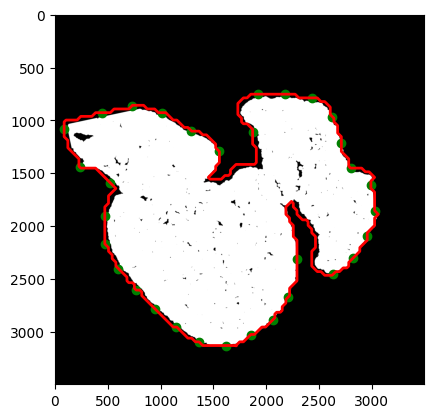

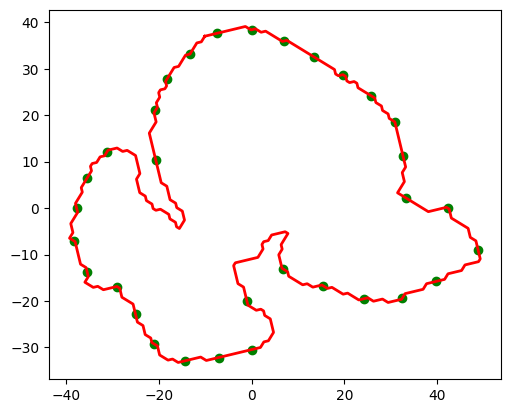

In [9]:
img, contour , anchors,  pca_contour, pca_anchors,pca = debugImage("../10.7d/heart3d_mask/zbfh_heart3d_s86.png",n=4,binsize=35)

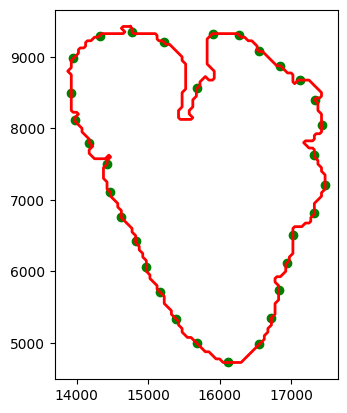

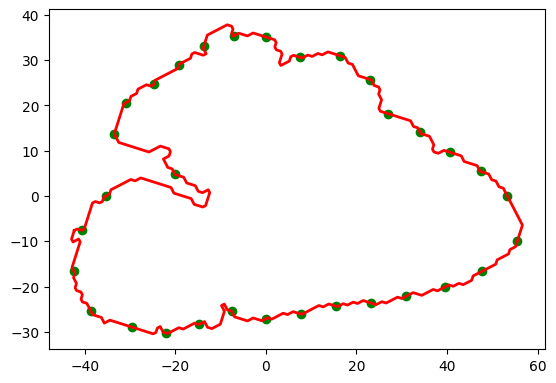

In [10]:
img_reg, contour_reg , anchors_reg,  pca_contour_reg, pca_anchors_reg, pca_reg = debugImage('T2_C3_S2.tif',drawimg=False,n=4,binsize=50)

In [11]:
match = Matching(anchors,anchors_reg,pca, pca_reg, pca_anchors, pca_anchors_reg,pca_contour,pca_contour_reg)

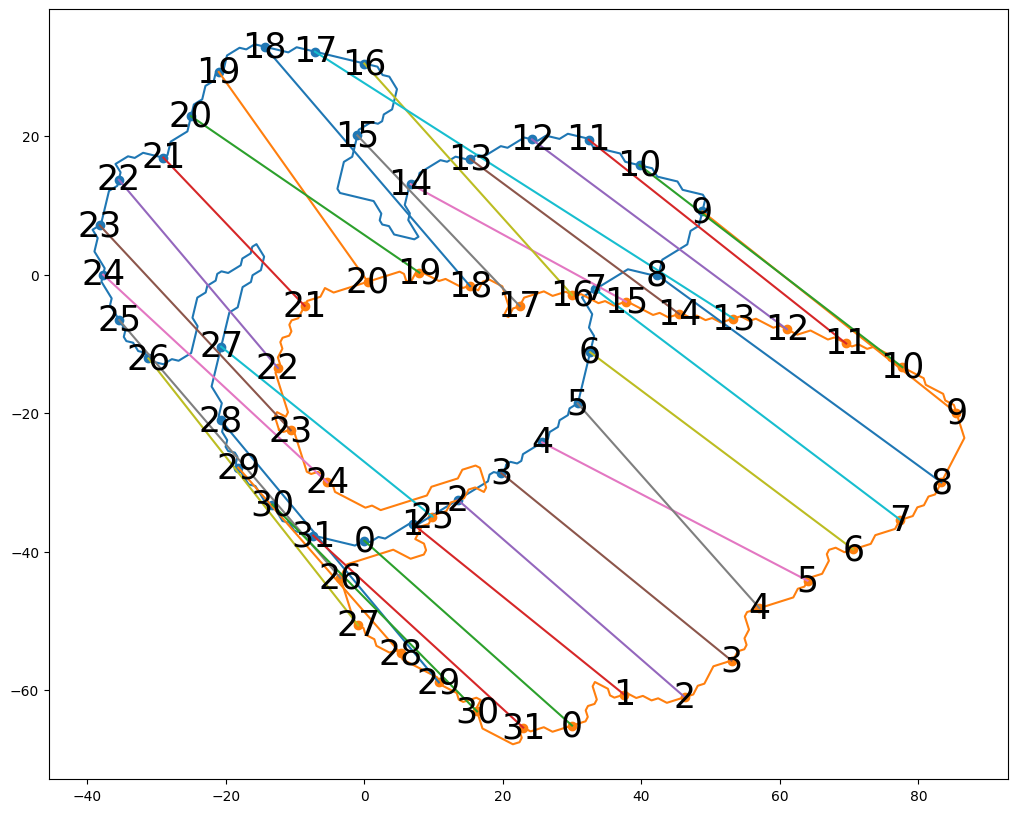

In [12]:
match.initAssignment()
match.drawMatchResult()
#match.drawAssignment()

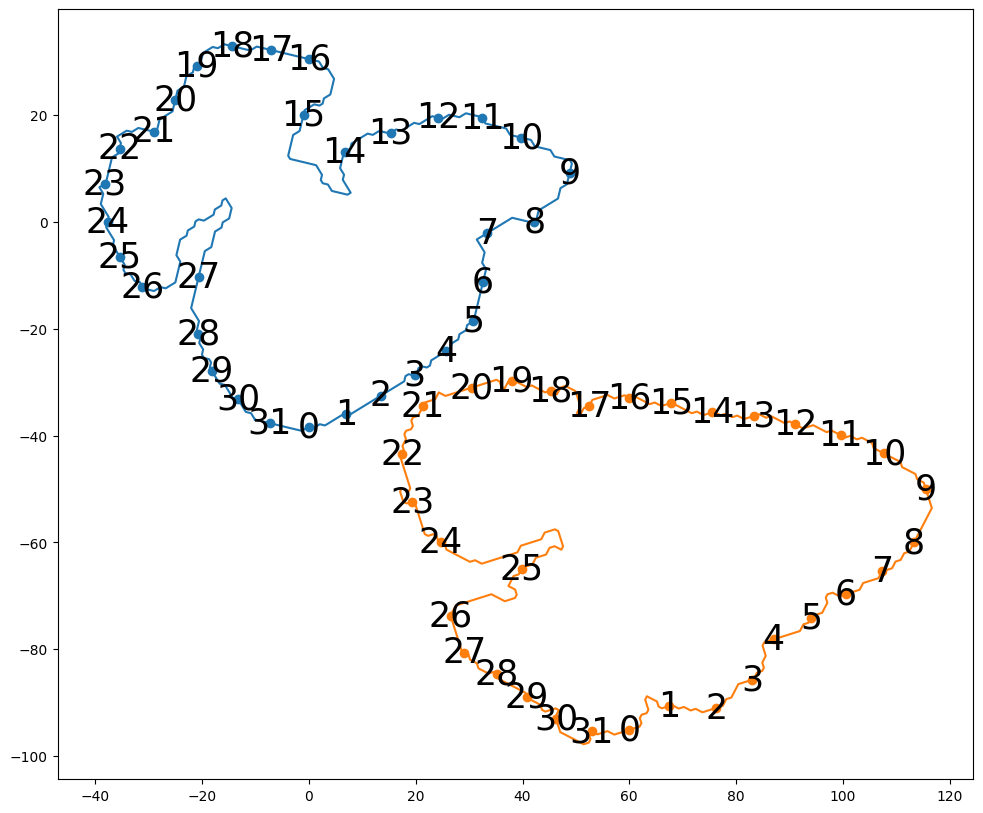

In [13]:
for i in range(32):
    match.delAnchorPair(i)
match.drawMatchResult(shift=60)

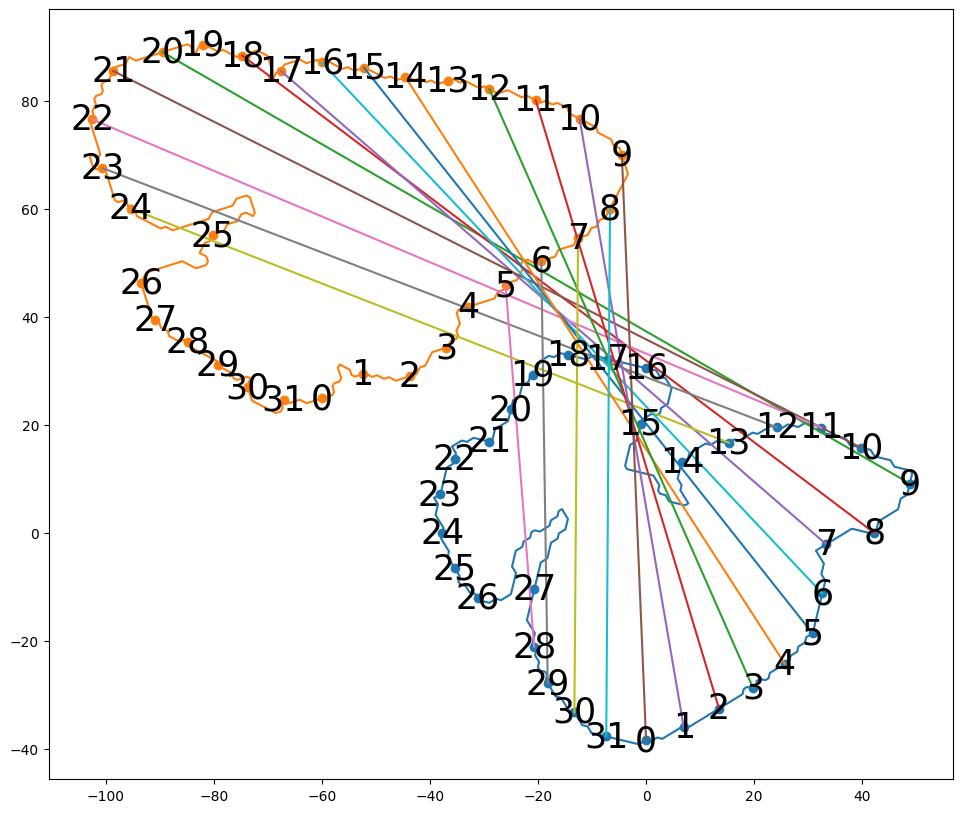

In [14]:
match.addAnchorPair(9,20)
match.addAnchorPair(8,18)
match.addAnchorPair(7,17)


match.addAnchorPair(10,21)
match.addAnchorPair(11,22)
match.addAnchorPair(12,23)
match.addAnchorPair(13,24)


match.addAnchorPair(6,16)
match.addAnchorPair(5,15)
match.addAnchorPair(4,14)
match.addAnchorPair(3,12)
match.addAnchorPair(2,11)
match.addAnchorPair(1,10)
match.addAnchorPair(0,9)

match.addAnchorPair(28,5)
match.addAnchorPair(29,6)
match.addAnchorPair(30,7)
match.addAnchorPair(31,8)

match.drawMatchResult(shift=-60)

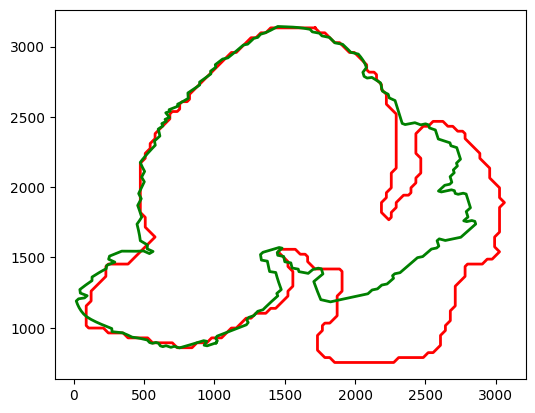

In [15]:
map_anchors_ref,map_anchors_reg = match.GetAnchors()
mapper = ImageMapper(img,img_reg,map_anchors_ref,map_anchors_reg)
mapper.drawContours(contour,contour_reg)

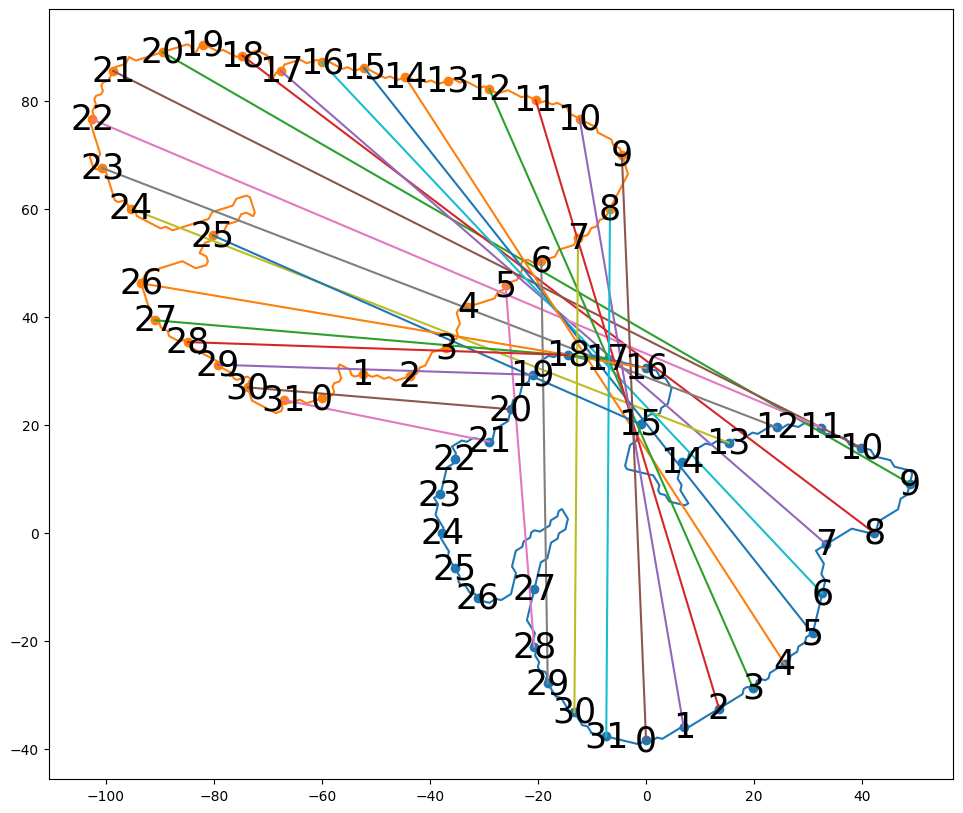

In [16]:
match.addAnchorPair(15,25)
match.addAnchorPair(16,26)
match.addAnchorPair(17,27)
match.addAnchorPair(18,28)
match.addAnchorPair(19,29)
match.addAnchorPair(20,30)
match.addAnchorPair(21,31)
match.drawMatchResult(shift=-60)

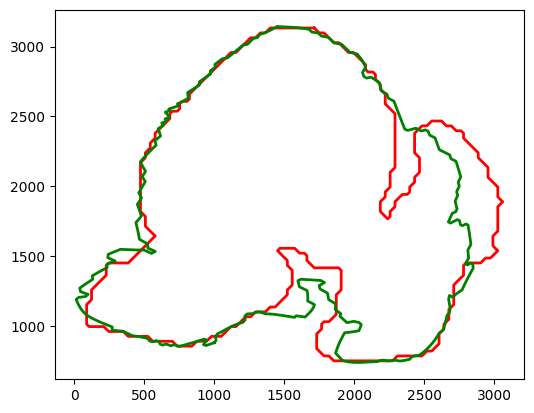

In [17]:
map_anchors_ref,map_anchors_reg = match.GetAnchors()
mapper = ImageMapper(img,img_reg,map_anchors_ref,map_anchors_reg)
mapper.drawContours(contour,contour_reg)

In [18]:
obs = pd.read_table('../regen_data/T2_celltype_meta.txt')
obs

,orig.ident,nCount_Spatial,nFeature_Spatial,x,y,nGenes,nUMI,Time,Chip,Heart,...,SCT_snn_res.1.3,SCT_snn_res.1.4,SCT_snn_res.1.5,SCT_snn_res.1.6,SCT_snn_res.1.7,SCT_snn_res.1.8,SCT_snn_res.1.9,SCT_snn_res.2,seurat_clusters,celltype
T2_C1_S1:cell106_302,T2_C1_S1,4898,1233,7452.762808,21175.200190,1233,4898,T2,C1,S1,...,0,0,0,0,0,0,0,0,0,Cardiomyocytes(Ventricle)_Endocardium(Ventricle)
T2_C1_S1:cell95_304,T2_C1_S1,4141,1072,6680.618312,21306.589946,1072,4141,T2,C1,S1,...,1,1,1,1,1,1,5,4,3,Cardiomyocytes(Atrium)_Redbloodcells
T2_C1_S1:cell114_302,T2_C1_S1,3544,936,8015.962500,21177.321429,936,3544,T2,C1,S1,...,0,0,0,0,0,0,0,0,0,Cardiomyocytes(Ventricle)_Endocardium(Ventricle)
T2_C1_S1:cell91_305,T2_C1_S1,6129,1445,6402.998987,21384.033181,1445,6129,T2,C1,S1,...,1,1,1,1,1,1,11,11,3,Cardiomyocytes(Atrium)_Redbloodcells
T2_C1_S1:cell115_315,T2_C1_S1,4942,1290,8085.654591,22081.215490,1290,4942,T2,C1,S1,...,2,2,2,2,2,2,1,1,4,Cardiomyocytes(dediff)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T2_C3_S6:cell254_110,T2_C3_S6,252,112,17806.337931,7755.137931,112,252,T2,C3,S6,...,3,3,3,3,3,4,2,3,1,Smoothmusclecells_Endocardium(frzb)
T2_C3_S6:cell251_104,T2_C3_S6,109,60,17585.538462,7286.974359,60,109,T2,C3,S6,...,10,15,15,15,16,17,16,16,8,Redbloodcells
T2_C3_S6:cell232_109,T2_C3_S6,112,47,16286.064516,7634.161290,47,112,T2,C3,S6,...,10,14,14,14,14,15,14,14,8,Redbloodcells
T2_C3_S6:cell246_130,T2_C3_S6,142,64,17230.476190,9111.916667,64,142,T2,C3,S6,...,0,0,0,0,0,0,0,0,0,Cardiomyocytes(Ventricle)_Endocardium(Ventricle)


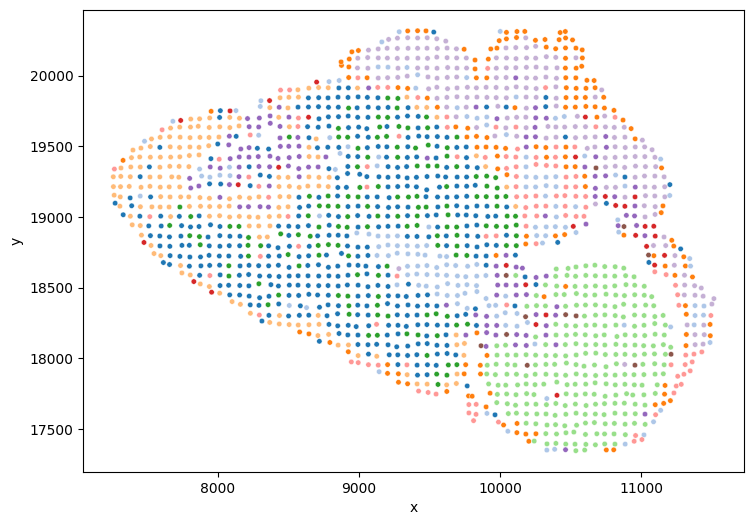

In [19]:
import seaborn as sns
plt.figure(figsize=(10,6))
draw=obs
draw = obs[obs['Heart']=='S2']
draw = draw[draw['Chip']=='C3']
sns.scatterplot(data=draw,x='x',y='y',hue='celltype',palette='tab20',s=15)
plt.gca().get_legend().remove()
plt.gca().set_aspect('equal')


In [20]:
gem2ssdna_affine = np.loadtxt('T2_C3_S2.affine.txt')

all_in_reg_gem = draw[['x','y']].to_numpy()
all_in_reg_gem1=np.insert(all_in_reg_gem,2,values=np.ones((all_in_reg_gem.shape[0],)),axis=1)
all_in_reg_ssdna = np.dot(gem2ssdna_affine,all_in_reg_gem1.T).T
all_in_reg_ssdna = all_in_reg_ssdna[:,:2]
all_in_reg_ssdna

array([[15744.31330786,  8005.49538873],
       [15113.91604186,  6781.42000716],
       [15429.74402168,  7436.29802719],
       ...,
       [14405.97834939,  8314.40037115],
       [14845.38155273,  7784.30147885],
       [13990.52765192,  8372.29731747]])

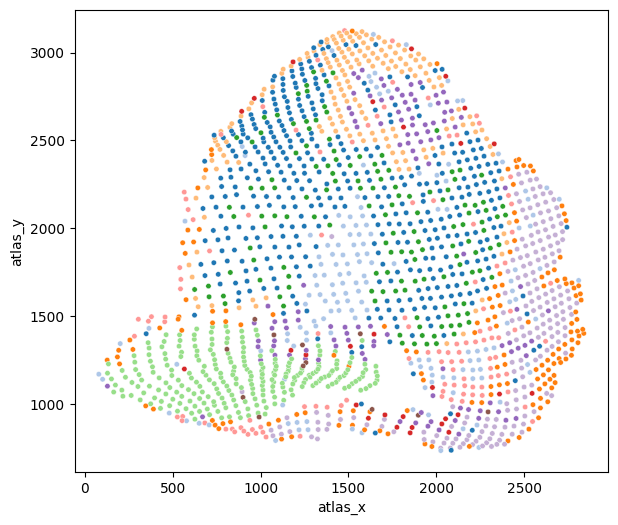

In [21]:
all_in_reg_ssdna = np.array(all_in_reg_ssdna)
all_in_ref = mapper.mapReg2Ref(all_in_reg_ssdna)
new = draw.copy()
new['atlas_x'] = all_in_ref[:,0]
new['atlas_y'] = all_in_ref[:,1]
plt.figure(figsize=(10,6))

sns.scatterplot(data=new,x='atlas_x',y='atlas_y',hue='celltype',palette='tab20',s=15)
plt.gca().get_legend().remove()
plt.gca().set_aspect('equal')

In [22]:
new['atlas_z'] = 86 * 14
new.to_csv('T2_C3_S2.csv',sep='\t',header=True,index=True)

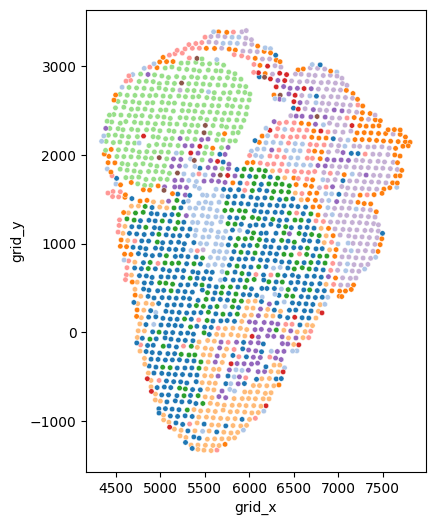

In [23]:
from skimage.transform import estimate_transform
from skimage.transform import AffineTransform

class GridMapper:
    def __init__(self,ref_p,reg_p):
        A = estimate_transform('affine',reg_p,ref_p)
        self.affine = AffineTransform(translation=A.translation,rotation=A.rotation,shear=A.shear)
    
    def mapp2Ref(self, reg):
        grid_reg_ssdna = np.vstack([reg.T,np.ones(reg.shape[0])])
        grid_in_ref1 = np.dot(self.affine,grid_reg_ssdna).T
        return grid_in_ref1[:,:2]

gmapper = GridMapper(map_anchors_ref,map_anchors_reg)
grid_in_ref1 = gmapper.mapp2Ref(all_in_reg_ssdna)
new['grid_x'] = grid_in_ref1[:,0]
new['grid_y'] = -grid_in_ref1[:,1]
new.to_csv('T2_C3_S2.csv',sep='\t',header=True,index=True)
plt.figure(figsize=(10,6))

sns.scatterplot(data=new,x='grid_x',y='grid_y',hue='celltype',palette='tab20',s=15)
plt.gca().get_legend().remove()
plt.gca().set_aspect('equal')